In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


# Project "How green is my city ?" - Inference

In this notebook, we perform the inference for the project "How Green is my city" (step 1):
- given city coordinates
- we take a pre-downloaded satellite image centered on this city
- we load the model of neural network that we have previously trained
- we feed this neural network with the new satellite image to perform the binary prediction green / built-up areas.
   

## Packages installation

In [3]:
!pip install rasterio

     |████████████████████████████████| 19.1MB 1.3MB/s 


In [4]:
!pip install pyrsgis

In [5]:
import os
import numpy as np
from tensorflow import keras

In [6]:
from pyrsgis import raster
from pyrsgis.convert import changeDimension

Warning! matplotlib_scalebar library not found. You may not be able to export map directly.


In [7]:
import rasterio
from rasterio.plot import show

# Ask for city coordinates and get satellite image

Note: in final version, the name of the city of interest should be asked to user and should be a parameter. Here it is fixed.

In [8]:
area = "Roquefort"

At the moment, we take a satellite image that has been already downloaded and croped (done in Jupyter notebook Create_shapefile_and_tiff_from_geo_coord.ipynb)

In [9]:
featuresFile_pred = '/content/drive/MyDrive/Colab Notebooks/Sentinel2_images/' + area + '_allbands.tiff'

# Load model and perform prediction

In [10]:
from keras.models import load_model

# load step1 pre-trained model
model = load_model('model_step1.h5')

In [11]:
# Read the rasters as array
ds, featuresPredArea = raster.read(featuresFile_pred, bands='all')

# We get 3D numpy array, with dimensions [band, row, col]
print(featuresPredArea.shape)  

(10, 827, 1047)


In [12]:
with rasterio.open(featuresFile_pred, 'r') as src:
  #featuresPredArea = src.read()  # read all raster values
  print(src.meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1047, 'height': 827, 'count': 10, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 338100.0,
       0.0, -10.0, 4841460.0)}


In [13]:
# Reshape the array to single dimensional array
featuresPredArea = changeDimension(featuresPredArea)

# Final image should be normalised as well
featuresPredArea = featuresPredArea / 65535.0

# Reshape the data
featuresPredArea = featuresPredArea.reshape((featuresPredArea.shape[0], 1, featuresPredArea.shape[1]))

# Print the shape of reshaped data
print(featuresPredArea.shape)

(865869, 1, 10)


In [14]:
# Predict new data
predicted = model.predict(featuresPredArea)
predicted = predicted[:,1]

# Green ratio computation

In [15]:
green_ratio = sum(predicted)/len(predicted)
print("Green ratio on this area:", green_ratio)

Green ratio on this area: 0.6803230017580022


# Visualisation of predicted image

A GeoTIFF is a standard .tif or image file format that includes additional spatial (georeferencing) information embedded in the .tif file as tags

In [16]:
# Convert again data to uint16 and export the probability raster
prediction = predicted * 65535.0
prediction = np.reshape(prediction, (ds.RasterYSize, ds.RasterXSize))
outFile = area + '_predicted.tif'
raster.export(prediction, ds, filename=outFile, dtype='uint16')

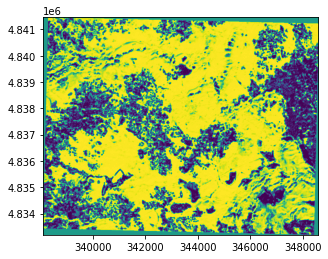

Image bounds: BoundingBox(left=338100.0, bottom=4833190.0, right=348570.0, top=4841460.0)
Image Coordinate Reference System: EPSG:32632


In [17]:
filename = area + '_predicted.tif'
with rasterio.open(filename) as img:
  show(img)
  print("Image bounds:", img.bounds)
  print("Image Coordinate Reference System:",img.crs )

## Visualisation on a map with folium
It would be nice to plot the mask on a map. We will use folium for that:

https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/ImageOverlay.ipynb


In [18]:
!pip install folium

In [19]:
import folium

folium.raster_layers.ImageOverlay() expects the raster array to correspond to World Geodetic System (WGS84) if we ask the function to perform the Mercator projection (mercator_project=True).
In addition, we need to know the bounds of the image, not the bounds of the data raster, expressed in latitude and longitude.
Therefore we perform a projection of our data in World Geodetic System (WGS84 -> EPSG:4326)

### World Geodetic System projection (WGS84)

Rasterio has a function to reproject.

https://rasterio.readthedocs.io/en/latest/topics/reproject.html?highlight=warp


In [20]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [21]:
def change_image_projection(filename, outfilename, dst_crs):
  # Function comes from here:
  # https://rasterio.readthedocs.io/en/latest/topics/reproject.html?highlight=warp
  # Reprojecting a GeoTIFF dataset from one coordinate reference system (CRS)
  # to another one
  with rasterio.open(filename) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(outfilename, 'w', **kwargs) as dst:
      for i in range(1, src.count + 1):
        reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [22]:
pred_file_wsg84 = area + '_predicted_EPSG4326.tif'
dst_crs = 'EPSG:4326' # World Geodetic System (WGS84) 
change_image_projection(filename, pred_file_wsg84, dst_crs)

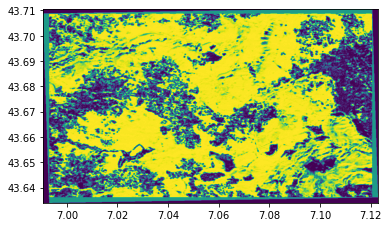

image bounds: BoundingBox(left=6.990476537287354, bottom=43.634050040830964, right=7.122690300870798, top=43.71071370050061)
CRS: EPSG:4326


In [23]:
with  rasterio.open(pred_file_wsg84) as img:
  prediction_wsg84 = img.read(1)
  show(img)
  print("image bounds:", img.bounds)
  image_box = img.bounds
  print("CRS:",img.crs)

In [24]:
N_lat = image_box.top
S_lat = image_box.bottom
W_long = image_box.left
E_long = image_box.right

In [25]:
# Center the map at the center of the area of interest, thanks to latitude and longitude coordinates:
m = folium.Map([(N_lat+S_lat)/2,(W_long+E_long)/2], zoom_start=11)

# Plot the mask on the map with folium ImageOverlay function 
folium.raster_layers.ImageOverlay(
    image=prediction_wsg84,
    bounds=[[S_lat, W_long], [N_lat, E_long]],
    opacity=0.5,
    interactive=True,
    cross_origin=False,
    colormap=lambda x: (0, 1, 0, x), # plot green areas in green
    mercator_project=True # Ask folium to do the mercator projection
).add_to(m)

m

### Mercator projection (WGS84)

Other way to plot the prediction mask with folium : we do ourselves the Mercator projection before calling folium.raster_layers.ImageOverlay()

In [28]:
pred_file_mercator = area + '_predicted_EPSG3857.tif'
dst_crs = 'EPSG:3857' # Mercator projection
change_image_projection(filename, pred_file_mercator, dst_crs)

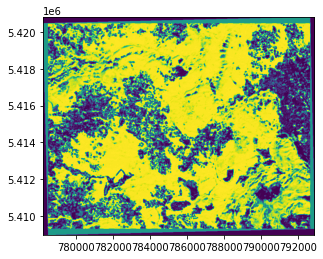

image bounds: BoundingBox(left=778176.2885331545, bottom=5408992.538966762, right=792897.1593915147, top=5420783.058067402)
CRS: EPSG:3857


In [29]:
with  rasterio.open(pred_file_mercator) as img:
  prediction_mercator = img.read(1)
  show(img)
  print("image bounds:", img.bounds)
  print("CRS:",img.crs)

In [30]:
# Center the map at the center of the area of interest, thanks to latitude and longitude coordinates:
m = folium.Map([(N_lat+S_lat)/2,(W_long+E_long)/2], zoom_start=11)

# Without Mercator projection 
folium.raster_layers.ImageOverlay(
    image=prediction_mercator,
    bounds=[[S_lat, W_long], [N_lat, E_long]],
    opacity=0.5,
    interactive=True,
    cross_origin=False,
    colormap=lambda x: (0, 1, 0, x), # plot green areas in green
    mercator_project=False # No need to reproject as we did it already
).add_to(m)

m

### Creation of tiles

We can also create tiles which can be used by many GIS visualisation tools (Folium, earthpy ...) This needs to be investigated ...

In [31]:
pip install gdal2tiles

     |████████████████████████████████| 204kB 9.2MB/s 
  Created wheel for gdal2tiles: filename=gdal2tiles-0.1.9-py2.py3-none-any.whl size=34227 sha256=cd8d0f7f65dbeb4e5b16581b174e315ad867ac913c61437b7fe639c4451a6518
  Stored in directory: /root/.cache/pip/wheels/a0/84/e0/38762a01f92137e955beb2f9d9d5160613ce9843aaf6e31a3c
Successfully built gdal2tiles


In [32]:
import gdal2tiles

In [33]:
mkdir mercator_tiles

mkdir: cannot create directory ‘mercator_tiles’: File exists


In [34]:
gdal2tiles.generate_tiles(pred_file_mercator, './mercator_tiles', s_srs='EPSG:3857')

Generating Base Tiles:
0...10...20...30...40...50...60...70...80...90...100
Generating Overview Tiles:
0...10...20...30...40...50...60...70...80...90...100


In [35]:
ls mercator_tiles/*

mercator_tiles/googlemaps.html  mercator_tiles/openlayers.html
mercator_tiles/leaflet.html     mercator_tiles/tilemapresource.xml

mercator_tiles/11:
1063/  1064/

mercator_tiles/12:
2127/  2128/  2129/

mercator_tiles/13:
4255/  4256/  4257/  4258/
